# Exploring the smoothness and curvature

In [15]:
# primary EDA code
import pandas as pd
import numpy as np
import os

# packages for plots
import matplotlib.pyplot as plt
import seaborn as sns

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for statistics
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# packages for fft
import spectrum
from spectrum import Periodogram, data_cosine

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Data readin
df_gp = pd.DataFrame()
for filename in os.listdir('../data/buy/'):
    if filename.endswith(".txt"): 
        stock = filename[0:4]
        # print("Loading stock data:", stock, ",")
        temp_df = pd.read_csv(os.path.join('../data/buy/', filename), delimiter= '\s+', header = None)
        temp_df.rename(columns={123:'rtn'}, inplace=True)
        temp_df = pd.concat([pd.Series([stock] * temp_df.shape[0], name = 'stock'), temp_df], axis=1)
        df_gp = pd.concat([df_gp, temp_df])
        continue
    else:
        continue
        
name_gp = df_gp.iloc[21:, 0]
osc_gp = df_gp.iloc[21:, 1:42]
stk_gp = df_gp.iloc[21:, 42:83]
macd_gp = df_gp.iloc[21:, 83:124]
rtn_gp = df_gp.iloc[21:, 124]
label_gp = np.sign(rtn_gp)
label_gp = label_gp.map({1: 1, -1: 0, 0:0})
results_gp = label_gp.map({1: 'EARN', 0: 'LOSS'})

osc_gp2 = round(osc_gp.iloc[:, 0],-1)
osc_gp2 = pd.Series(osc_gp2, name = 'OSC_grp')
osc_mag_to_lbl_analysis_df = pd.concat([name_gp, osc_gp2, label_gp],axis=1)
osc_grp_plot = osc_mag_to_lbl_analysis_df.groupby(['stock','OSC_grp']).mean().reset_index()


def EDA(index, osc_ind = True, stk_ind = True, macd_ind = True, style = 'bmh', figsize=(7,7)):
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        num_layout = np.sum([osc_ind, stk_ind, macd_ind])
        layout = (num_layout, 1)

        if osc_ind:
            osc_ax = plt.subplot2grid(layout, (0, 0))
            osc_ax.plot(range(41), osc.iloc[index,:])
            osc_ax.invert_xaxis()
            plt.hlines(0, xmin=0, xmax=40, colors='k',linestyles = "dashed")
            osc_ax.set_title('Oscillator 3-Day Time Series')
            osc_ax.set_xlabel('Time')
            osc_ax.set_ylabel('Oscillator')
        
        if stk_ind:
            stk_ax = plt.subplot2grid(layout, (1, 0))
            stk_ax.plot(range(41), stk.iloc[index,:])
            stk_ax.invert_xaxis()
            stk_ax.set_title('Stock Price 3-Day Time Series')
            stk_ax.set_xlabel('Time')
            stk_ax.set_ylabel('Stock Price')
        
        if macd_ind:
            macd_ax = plt.subplot2grid(layout, (2, 0))
            macd_ax.plot(range(41), macd.iloc[index,:])
            macd_ax.invert_xaxis()
            plt.hlines(0, xmin=0, xmax=40, colors='k', linestyles = "dashed")
            macd_ax.set_title('MACD 3-Day Time Series')
            macd_ax.set_xlabel('Time')
            macd_ax.set_ylabel('MACD')
        
        plt.tight_layout()

# Smoothness calculation

The most general way to measure the smoothness of a curve is `np.var(np.diff(x))`

In [22]:
smooth = []
for i in range(osc_gp.shape[0]):
    smooth.append(np.var(abs(np.diff(osc_gp.iloc[i,:]))))



Max var 43.552214000000006
Min var 9.749999999999998e-06


Text(0.5,1,'Oscillator 3-Day Time Series with smaller smoothness')

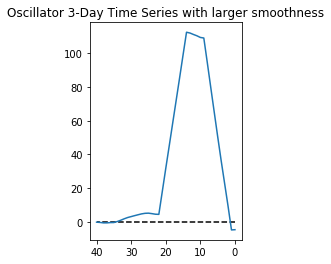

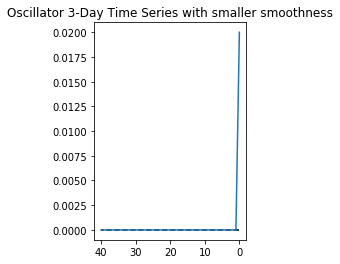

In [29]:
# find the index for max and min smoothness
index_max = np.argmax(smooth)
print("Max var", smooth[index_max])
index_min = np.argmin(smooth)
print("Min var", smooth[index_min])

fig = plt.figure()
layout = (1, 2)
osc_ax_max = plt.subplot2grid(layout, (0, 0))
osc_ax_max.plot(range(41), osc_gp.iloc[index_max,:])
osc_ax_max.invert_xaxis()
plt.hlines(0, xmin=0, xmax=40, colors='k',linestyles = "dashed")
osc_ax_max.set_title('Oscillator 3-Day Time Series with larger smoothness')

fig = plt.figure()
layout = (1, 2)
osc_ax_min = plt.subplot2grid(layout, (0, 1))
osc_ax_min.plot(range(41), osc_gp.iloc[index_min,:])
osc_ax_min.invert_xaxis()
plt.hlines(0, xmin=0, xmax=40, colors='k',linestyles = "dashed")
osc_ax_min.set_title('Oscillator 3-Day Time Series with smaller smoothness')



# Explore the relationship between smoothness and return

In [82]:
#plt.scatter(smooth, rtn_gp)
df_smoo_rtn = pd.DataFrame({"smooth": smooth,
                           "rtn": rtn_gp})

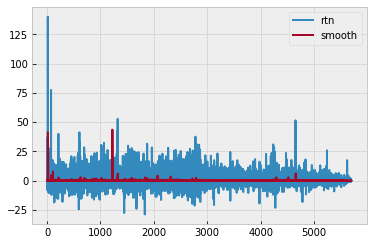

In [39]:
with plt.style.context(style = 'bmh'):
    df_smoo_rtn.plot()

As we can observe from the plot above, there are some interesting points, on which the behaviour of the return value agrees with the smoothness.

We can then take a deeper look for this relationship.

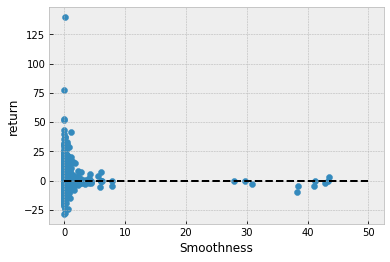

In [54]:
with plt.style.context(style = 'bmh'):
    plt.scatter(df_smoo_rtn["smooth"], df_smoo_rtn["rtn"])
    plt.hlines(0, xmin=0, xmax = 50, colors='k',linestyles = "dashed")
    plt.xlabel("Smoothness")
    plt.ylabel("return")

Most of the points are gethered around smoothness lower than 1, we can then zoom in that area.

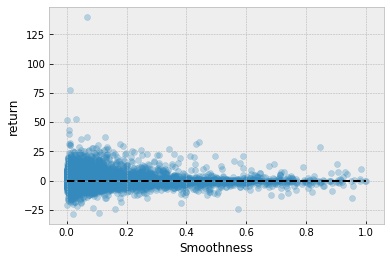

In [89]:
df_smoo_rtn_zoomin = df_smoo_rtn[df_smoo_rtn["smooth"]<1]

with plt.style.context(style = 'bmh'):
    plt.scatter(df_smoo_rtn_zoomin["smooth"], df_smoo_rtn_zoomin["rtn"],alpha=0.3, marker="o")
    plt.hlines(0, xmin=0, xmax=1, colors='k',linestyles = "dashed")
    plt.xlabel("Smoothness")
    plt.ylabel("return")

For curves with lower smoothness, the return value > 0 has a higher proportion?

# Explore the relationship between smoothness and label

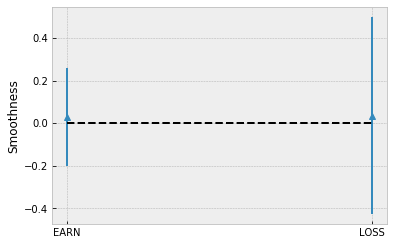

In [134]:
df_smoo_lab = pd.DataFrame({"smooth": smooth,
                           "label": results_gp})

df_smoo_mean = df_smoo_lab.groupby("label").mean().reset_index()
df_smoo_std = df_smoo_lab.groupby("label").std().reset_index()
#    
#        fig = plt.figure(figsize=(10, 7))
#        layout = (1, 1)
#        ax = plt.subplot2grid(layout, (0, 0))
df_results = pd.merge(df_smoo_mean, df_smoo_std,
                       how='left', on=["label"])
# df_results
with plt.style.context('bmh'):
    plt.errorbar(df_results["label"], df_results["smooth_x"], df_results["smooth_y"], linestyle='None', marker='^')
    plt.hlines(0, xmin="EARN", xmax = "LOSS", colors='k',linestyles = "dashed")
    plt.ylabel("Smoothness")

As we can observe, for the curve that returns loss, the variation of the smoothness is bigger. 

# Curvature Calculation
